Notebook outlining what functions from nltk will be useful for pre-processing the text and training the classification algorithm.

Expects a CSV file in the current directory containing a release's date, text, and classification (pos or neg) in each row.

In [13]:
import math
import pandas as pd
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

from sklearn import decomposition, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Some pre-processing to get the dataframe into the format we need for content analysis:

`allreleasescleaned.csv` contains all press releases from 1994 to 2018.

In [156]:
histreleasesdf = pd.read_csv('allreleasescleaned.csv', index_col=0)

In [158]:
histreleasesdf.head()

,date,release_text,year,month
0,"November 15, 1994",The Federal Reserve Board today approved an in...,1994,November
1,"August 16, 1994",The Federal Reserve announced today the follow...,1994,August
2,"May 17, 1994",The Federal Reserve today announced two action...,1994,May
3,"April 18, 1994",Chairman Alan Greenspan announced today that t...,1994,April
4,"March 22, 1994",Chairman Alan Greenspan announced today that ...,1994,March


`allratesdf.csv` contains cleaned DataFrame of all relevant rate changes from 1994.

In [162]:
allratesdf = pd.read_csv('allratesdf.csv', index_col=0)

In [166]:
allratesdf.head()

,month,year,Change,increase
0,February,1994,0.07,True
1,March,1994,0.03,True
2,April,1994,0.07,True
3,May,1994,0.13,True
4,June,1994,0.06,True


Now, to merge the text and rates DataFrames and clean the result. `allreleaserates.csv` has all rate changes since 1994 and their associated release text.

Now text processing using `nltk`.

In [194]:
releaserates_df = pd.read_csv('allreleaserates.csv', index_col=0)

In [195]:
releaserates_df.head()

,month,year,Change,increase,date,release_text
0,February,1994,0.07,True,"February 4, 1994",Chairman Alan Greenspan announced today that t...
1,March,1994,0.03,True,"March 22, 1994",Chairman Alan Greenspan announced today that ...
2,April,1994,0.07,True,"April 18, 1994",Chairman Alan Greenspan announced today that t...
3,May,1994,0.13,True,"May 17, 1994",The Federal Reserve today announced two action...
4,June,1994,0.06,True,"May 17, 1994",The Federal Reserve today announced two action...


### LOGISTIC REGRESSION

First, we try a Logistic Regression using PCA on tf-idf vectors.

In [196]:
x_train, x_test, y_train, y_test = train_test_split(releaserates_df['release_text'], releaserates_df['increase'], test_size = .30, random_state = 42)

In [197]:
releaseTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')

In [198]:
releaseTFVects = releaseTFVectorizer.fit_transform(x_train)

If interested in the scores assigned to words:

In [187]:
#sorted(list(zip(releaseTFVectorizer.vocabulary_.keys(), releaseTFVects.data)), key=lambda x: x[1], reverse=True)

In [199]:
PCA = decomposition.PCA
pca = PCA().fit(releaseTFVects.toarray())
reduced_data = pca.transform(releaseTFVects.toarray())

A Scree Plot indicating the proportion of variance explained by the first $x$ principal components.

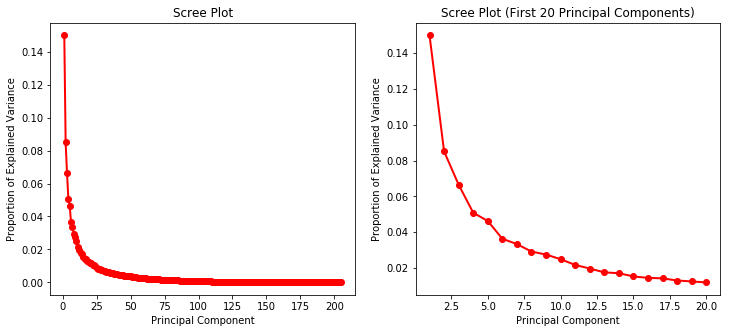

In [200]:
n = releaseTFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

We'll first try a Logistic Regression using the first 10 principal components as regressors.

In [201]:
X = reduced_data[:, :10]
Y = np.array([int(label) for label in y_train])

In [202]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [203]:
print('For training set: {}'.format(logistic.score(X,Y)))

For training set: 0.6536585365853659


In [204]:
releaseTFVects_test = releaseTFVectorizer.transform(x_test)
reduced_data_test = pca.transform(releaseTFVects_test.toarray())
X_test = reduced_data_test[:, :10]
Y_test = np.array([int(label) for label in y_test])
print('For testing set: {}'.format(logistic.score(X_test, Y_test)))

For testing set: 0.550561797752809


Not so good...

How about 21 principal components? (Seems like a reasonable knee in the scree plot)

In [205]:
X = reduced_data[:, :21]
Y = np.array([int(label) for label in y_train])

In [206]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)
print('For training set: {}'.format(logistic.score(X,Y)))

For training set: 0.7365853658536585


In [207]:
releaseTFVects_test = releaseTFVectorizer.transform(x_test)
reduced_data_test = pca.transform(releaseTFVects_test.toarray())
X_test = reduced_data_test[:, :21]
Y_test = np.array([int(label) for label in y_test])
print('For testing set: {}'.format(logistic.score(X_test, Y_test)))

For testing set: 0.5617977528089888


After this point, more components doesn't result in much of an increase in predictive power. But, this still isn't great. To solve this problem, we should try different classifying algorithms.

### NAIVE BAYES

In [209]:
#releaserates_df.iloc[125:]
releaserates_df.iloc[269:]

,month,year,Change,increase,date,release_text
269,January,2016,0.42,True,"January 27, 2016",Information received since the Federal Open Ma...
270,February,2016,0.12,True,"January 27, 2016",Information received since the Federal Open Ma...
271,March,2016,-0.05,False,"March 16, 2016",Information received since the Federal Open Ma...
272,April,2016,0.03,True,"April 27, 2016",Information received since the Federal Open Ma...
273,May,2016,0.00,False,"April 27, 2016",Information received since the Federal Open Ma...
274,June,2016,0.03,True,"June 15, 2016",Information received since the Federal Open Ma...
275,July,2016,0.03,True,"July 27, 2016",Information received since the Federal Open Ma...
276,August,2016,0.03,True,"July 27, 2016",Information received since the Federal Open Ma...
277,September,2016,0.00,False,"September 21, 2016",Information received since the Federal Open Ma...
278,October,2016,0.00,False,"September 21, 2016",Information received since the Federal Open Ma...


In [280]:
#x_train, x_test, y_train, y_test = train_test_split(releaserates_df['release_text'], releaserates_df['increase'], test_size = .30, random_state = 42)
#train_df = pd.DataFrame({'release_text':x_train, 'increase':y_train})
#test_df = pd.DataFrame({'release_text':x_test, 'increase' : y_test})

# settings for testing on releases after Jan 2017 (with data since 2006)
#train_df = releaserates_df.iloc[:137].copy()
#test_df = releaserates_df.iloc[137:].copy()

# with data since 1994
#train_df = releaserates_df.iloc[:281].copy()
#test_df = releaserates_df.iloc[281:].copy()

# settings for testing on releases after Jan 2016 (with data since 2006)
#train_df = releaserates_df.iloc[:125].copy()
#test_df = releaserates_df.iloc[125:].copy()

# with data since 1994
train_df = releaserates_df.iloc[:269].copy()
test_df = releaserates_df.iloc[269:].copy()

TODO
- Try Leave One Out testing [DONE]
- Better model descriptions
- Include past releases [DONE]
- Include unemployment as another (or comparison) variable
- Determine most characteristic words

In [281]:
clf = sklearn.naive_bayes.GaussianNB()
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=15, stop_words='english', norm='l2')

TFVects = TFVectorizer.fit_transform(train_df['release_text'])
train_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

TFVects_test = TFVectorizer.transform(test_df['release_text'])
test_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [257]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_df['vect'], axis=0), train_df['increase'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [258]:
print("Training:")
print(naiveBayes.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print("Testing:")
print(naiveBayes.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training:
0.8113879003558719
Testing:
0.8461538461538461


In [259]:
y_pred = naiveBayes.predict(np.stack(test_df['vect'], axis=0))
print(classification_report(test_df['increase'], y_pred))

             precision    recall  f1-score   support

      False       0.00      0.00      0.00         2
       True       0.85      1.00      0.92        11

avg / total       0.72      0.85      0.78        13



/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### DECISION TREE

In [260]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_df['vect'], axis =0), train_df['increase'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [261]:
print("Training:")
print(sklearn.metrics.accuracy_score(train_df['increase'],clf_tree.predict(np.stack(train_df['vect'], axis = 0))))
print("Testing:")
print(sklearn.metrics.accuracy_score(test_df['increase'],clf_tree.predict(np.stack(test_df['vect'], axis = 0))))

Training:
0.5871886120996441
Testing:
0.8461538461538461


In [262]:
y_pred = clf_tree.predict(np.stack(test_df['vect'], axis=0))
print(classification_report(test_df['increase'], y_pred))

             precision    recall  f1-score   support

      False       0.00      0.00      0.00         2
       True       0.85      1.00      0.92        11

avg / total       0.72      0.85      0.78        13



/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### BAGGING

In [282]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [283]:
bag.fit(np.stack(train_df['vect'], axis =0), train_df['increase']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [284]:
print("Training:")
print(bag.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print("Testing:")
print(bag.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training:
0.8438661710037175
Testing:
0.24


In [285]:
y_pred = bag.predict(np.stack(test_df['vect'], axis=0))
print(classification_report(test_df['increase'], y_pred))

             precision    recall  f1-score   support

      False       0.19      0.67      0.30         6
       True       0.50      0.11      0.17        19

avg / total       0.43      0.24      0.20        25



### KNN

In [266]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [267]:
clf_knearest.fit(np.stack(train_df['vect'], axis = 0), train_df['increase'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [268]:
print('Training: ')
print(clf_knearest.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print('Testing: ')
print(clf_knearest.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training: 
0.6725978647686833
Testing: 
0.6923076923076923


### SVM

#### Linear

In [269]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
clf_svm.fit(np.stack(train_df['vect'], axis=0), train_df['increase'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [270]:
print('Training: ')
print(clf_svm.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print('Testing: ')
print(clf_svm.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training: 
0.8256227758007118
Testing: 
0.8461538461538461


#### Cubic

In [271]:
clf_svm = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = False)
clf_svm.fit(np.stack(train_df['vect'], axis=0), train_df['increase'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [272]:
print('Training: ')
print(clf_svm.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print('Testing: ')
print(clf_svm.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training: 
0.501779359430605
Testing: 
0.15384615384615385


### NEURAL NETS

In [299]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_df['vect'], axis=0), train_df['increase'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [300]:
print('Training: ')
print(clf_nn.score(np.stack(train_df['vect'], axis=0), train_df['increase']))
print('Testing: ')
print(clf_nn.score(np.stack(test_df['vect'], axis=0), test_df['increase']))

Training: 
0.8661710037174721
Testing: 
0.84


In [301]:
y_pred = clf_nn.predict(np.stack(test_df['vect'], axis=0))
print(classification_report(test_df['increase'], y_pred))

             precision    recall  f1-score   support

      False       1.00      0.33      0.50         6
       True       0.83      1.00      0.90        19

avg / total       0.87      0.84      0.81        25



Woohoo!

Looks like using a Neural Net or Bagging model is our best bet.

### LOOCV

In [302]:
from sklearn.model_selection import LeaveOneOut

In [316]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=15, stop_words='english', norm='l2')

TFVects = TFVectorizer.fit_transform(releaserates_df['release_text'])

releaserates_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

yvals = releaserates_df['increase'].apply(lambda x: int(x)).values
Xvals = releaserates_df['vect'].values

#### For Neural Net

In [323]:
N_loo = Xvals.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
MSE_vec = np.zeros(N_loo)
y_pred_vals = []

# This loop takes several minutes
for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    clf_nn = sklearn.neural_network.MLPClassifier()
    clf_nn.fit(np.stack(X_train, axis=0), y_train)
    y_pred = clf_nn.predict(np.stack(X_test, axis=0))
    y_pred_vals.append(y_pred)
    MSE_vec[test_index] = (y_test - y_pred) ** 2
    print('MSE for test set', test_index, ' is', MSE_vec[test_index])

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

MSE for test set [0]  is [0.]
MSE for test set [1]  is [0.]
MSE for test set [2]  is [0.]


/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MSE for test set [3]  is [0.]
MSE for test set [4]  is [0.]
MSE for test set [5]  is [0.]
MSE for test set [6]  is [0.]
MSE for test set [7]  is [0.]
MSE for test set [8]  is [0.]
MSE for test set [9]  is [0.]
MSE for test set [10]  is [0.]
MSE for test set [11]  is [0.]
MSE for test set [12]  is [1.]
MSE for test set [13]  is [1.]
MSE for test set [14]  is [1.]
MSE for test set [15]  is [1.]
MSE for test set [16]  is [1.]
MSE for test set [17]  is [0.]
MSE for test set [18]  is [1.]
MSE for test set [19]  is [1.]
MSE for test set [20]  is [0.]
MSE for test set [21]  is [1.]
MSE for test set [22]  is [0.]
MSE for test set [23]  is [0.]
MSE for test set [24]  is [0.]
MSE for test set [25]  is [1.]
MSE for test set [26]  is [1.]
MSE for test set [27]  is [1.]
MSE for test set [28]  is [1.]
MSE for test set [29]  is [1.]
MSE for test set [30]  is [0.]
MSE for test set [31]  is [1.]
MSE for test set [32]  is [0.]
MSE for test set [33]  is [1.]
MSE for test set [34]  is [0.]
MSE for test se

MSE for test set [263]  is [0.]
MSE for test set [264]  is [0.]
MSE for test set [265]  is [0.]
MSE for test set [266]  is [0.]
MSE for test set [267]  is [0.]
MSE for test set [268]  is [0.]
MSE for test set [269]  is [0.]
MSE for test set [270]  is [0.]
MSE for test set [271]  is [1.]
MSE for test set [272]  is [1.]
MSE for test set [273]  is [1.]
MSE for test set [274]  is [1.]
MSE for test set [275]  is [0.]
MSE for test set [276]  is [0.]
MSE for test set [277]  is [0.]
MSE for test set [278]  is [0.]
MSE for test set [279]  is [1.]
MSE for test set [280]  is [0.]
MSE for test set [281]  is [0.]
MSE for test set [282]  is [0.]
MSE for test set [283]  is [0.]
MSE for test set [284]  is [0.]
MSE for test set [285]  is [0.]
MSE for test set [286]  is [0.]
MSE for test set [287]  is [0.]
MSE for test set [288]  is [0.]
MSE for test set [289]  is [0.]
MSE for test set [290]  is [0.]
MSE for test set [291]  is [1.]
MSE for test set [292]  is [0.]
MSE for test set [293]  is [0.]
test est

In [331]:
print(classification_report(yvals, np.asarray(y_pred_vals)))

             precision    recall  f1-score   support

          0       0.67      0.69      0.68       143
          1       0.69      0.68      0.68       151

avg / total       0.68      0.68      0.68       294



Not super great, but maybe it doesn't matter? As long as it works for more recent releases?

#### For Bagging

In [333]:
y_pred_vals2 = []
#this loop takes several minutes
for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.
    bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data
    bag.fit(np.stack(X_train, axis =0), y_train) #Fit the bagged classifier
    y_pred = bag.predict(np.stack(X_test, axis=0))
    y_pred_vals2.append(y_pred)
    MSE_vec[test_index] = (y_test - y_pred) ** 2
    print('MSE for test set', test_index, ' is', MSE_vec[test_index])

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

MSE for test set [0]  is [0.]
MSE for test set [1]  is [0.]
MSE for test set [2]  is [0.]
MSE for test set [3]  is [0.]
MSE for test set [4]  is [0.]
MSE for test set [5]  is [0.]
MSE for test set [6]  is [0.]
MSE for test set [7]  is [0.]
MSE for test set [8]  is [0.]
MSE for test set [9]  is [0.]
MSE for test set [10]  is [0.]
MSE for test set [11]  is [0.]
MSE for test set [12]  is [0.]
MSE for test set [13]  is [0.]
MSE for test set [14]  is [0.]
MSE for test set [15]  is [1.]
MSE for test set [16]  is [1.]
MSE for test set [17]  is [1.]
MSE for test set [18]  is [1.]
MSE for test set [19]  is [1.]
MSE for test set [20]  is [1.]
MSE for test set [21]  is [1.]
MSE for test set [22]  is [0.]
MSE for test set [23]  is [1.]
MSE for test set [24]  is [1.]
MSE for test set [25]  is [1.]
MSE for test set [26]  is [1.]
MSE for test set [27]  is [1.]
MSE for test set [28]  is [1.]
MSE for test set [29]  is [1.]
MSE for test set [30]  is [1.]
MSE for test set [31]  is [1.]
MSE for test set [

MSE for test set [260]  is [0.]
MSE for test set [261]  is [0.]
MSE for test set [262]  is [0.]
MSE for test set [263]  is [0.]
MSE for test set [264]  is [0.]
MSE for test set [265]  is [0.]
MSE for test set [266]  is [0.]
MSE for test set [267]  is [0.]
MSE for test set [268]  is [1.]
MSE for test set [269]  is [0.]
MSE for test set [270]  is [0.]
MSE for test set [271]  is [1.]
MSE for test set [272]  is [0.]
MSE for test set [273]  is [1.]
MSE for test set [274]  is [0.]
MSE for test set [275]  is [0.]
MSE for test set [276]  is [0.]
MSE for test set [277]  is [0.]
MSE for test set [278]  is [0.]
MSE for test set [279]  is [1.]
MSE for test set [280]  is [0.]
MSE for test set [281]  is [0.]
MSE for test set [282]  is [0.]
MSE for test set [283]  is [0.]
MSE for test set [284]  is [0.]
MSE for test set [285]  is [0.]
MSE for test set [286]  is [0.]
MSE for test set [287]  is [0.]
MSE for test set [288]  is [0.]
MSE for test set [289]  is [0.]
MSE for test set [290]  is [0.]
MSE for 

In [334]:
print(classification_report(yvals, np.asarray(y_pred_vals2)))

             precision    recall  f1-score   support

          0       0.70      0.52      0.60       143
          1       0.64      0.79      0.70       151

avg / total       0.67      0.66      0.65       294

